# Import thư viện

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict


# Đọc dữ liệu từ file CSV

In [3]:
dataset = 'drive/MyDrive/COURSES/CS116/XGBoost/'
df_train = pd.read_csv(dataset + 'train.csv', sep=",")
df_test = pd.read_csv(dataset + 'test.csv', sep=",")
df_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


# Phân tích dữ liệu

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [5]:
df_train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


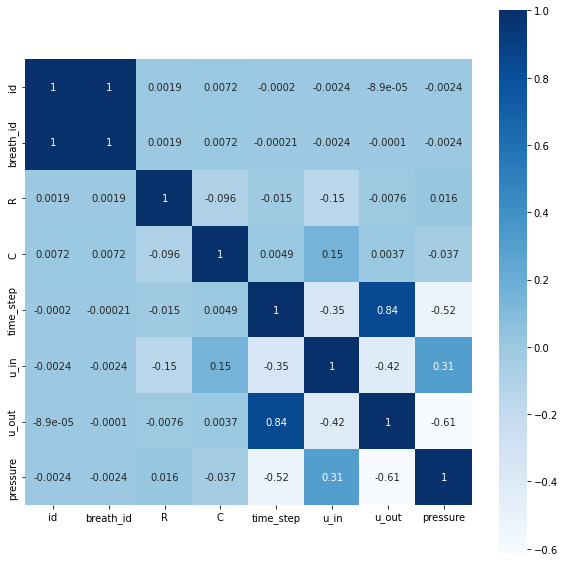

In [6]:
correlation = df_train.corr(method='pearson')

fig = plt.subplots(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='Blues')

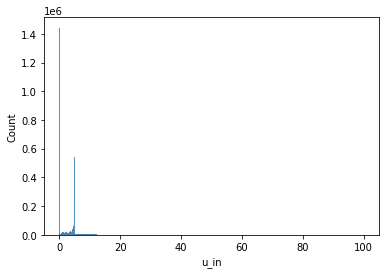

In [7]:
df_train['u_in'].max()
sns.histplot(df_train['u_in'])

In [8]:
# sns.histplot(train['u_out'])
df_train['u_out'].value_counts()

1    3745032
0    2290968
Name: u_out, dtype: int64

In [9]:
cat_cols = []
num_cols = []
for col in df_train.columns:
    if(df_train[col].value_counts().count() < 10):
        cat_cols.append(col)
    else:
        num_cols.append(col)
    print(col + '---' + str(df_train[col].value_counts().count()))

id---6036000
breath_id---75450
R---3
C---3
time_step---3767571
u_in---4020248
u_out---2
pressure---950


In [10]:
for col in cat_cols:
    print(col + '---' + str(df_train[col].unique()))

R---[20 50  5]
C---[50 20 10]
u_out---[0 1]


In [11]:
num_cols

['id', 'breath_id', 'time_step', 'u_in', 'pressure']

In [12]:
Q1 = df_train.quantile(0.25)
Q3 = df_train.quantile(0.75)
IQR = Q3 - Q1
((df_train < (Q1 - 1.5 * IQR)) | (df_train > (Q3 + 1.5 * IQR))).sum()

id                0
breath_id         0
R                 0
C                 0
time_step         0
u_in         836873
u_out             0
pressure     594709
dtype: int64

In [13]:
Q1 = df_test.quantile(0.25)
Q3 = df_test.quantile(0.75)
testIQR = Q3 - Q1
((df_test < (Q1 - 1.5 * testIQR)) | (df_test > (Q3 + 1.5 * testIQR))).sum()

id                0
breath_id         0
R                 0
C                 0
time_step         0
u_in         556601
u_out             0
dtype: int64

# Tiền xử lý dữ liệu

In [14]:
df_train['breath_id'].unique()

array([     1,      2,      3, ..., 125743, 125745, 125749])

In [15]:
y = df_train['pressure']
X = df_train.drop(columns=['pressure'])
X.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,1,20,50,0.000000,0.083334,0
1,2,1,20,50,0.033652,18.383041,0
2,3,1,20,50,0.067514,22.509278,0
3,4,1,20,50,0.101542,22.808822,0
4,5,1,20,50,0.135756,25.355850,0


# Grid Search

In [16]:
# param = {
#               'gamma': [0.1, 0.6, 1.2, 3.2],
#               'learning_rate': [0.001, 0.01, 0.05, 0.1],
#               'max_depth': [2, 3, 5, 8],
#               'n_estimators': [5000],
#               'subsample': [0.95],
#               'colsample_bytree': [0.1, 0.6],
#               'booster': ['gbtree'], 
#               'reg_lambda': [66.1],
#               'reg_alpha': [15.9],
#               'tree_method': ['gpu_hist'],
#               'gpu_id': [0],
#               'predictor': ['gpu_predictor']
#           }

In [17]:
# gd_sr = GridSearchCV(estimator=XGBRegressor(),
#                      param_grid=param,
#                      scoring='neg_mean_absolute_error',
#                      cv=5,
#                      verbose=4)
# gd_sr

In [18]:
# gd_sr.fit(X, y)

In [19]:
# best_parameters = gd_sr.best_params_
# print(best_parameters)

In [20]:
# best_result = gd_sr.best_score_
# print(best_result)

In [21]:
best_best_param = {'booster': 'gbtree', 'colsample_bytree': 0.6, 'gamma': 3.2, 'gpu_id': 0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 5000, 'predictor': 'gpu_predictor', 'reg_alpha': 15.9, 'reg_lambda': 66.1, 'subsample': 0.95, 'tree_method': 'gpu_hist'}

# Huấn luyện 

In [22]:
best_model = XGBRegressor(**best_best_param)

In [32]:
import time 
import pickle
file_name = "xgb_reg.pkl"

start = time.time()
best_model.fit(X, y)
end = time.time() 

# pickle.dump(best_model, open(file_name, "wb"))
best_model.save_model('model.json')

print('Time to train {}'.format(end - start))

[07:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time to train 148.180025100708


In [33]:
from joblib import dump
dump(best_model, "pima.joblib.dat")

['pima.joblib.dat']

In [24]:
# cv_svm = KFold(n_splits=5, random_state=0, shuffle=True)
# clf_cv_svm = SVC(random_state=0, C=best_parameters['C'], gamma=best_parameters['gamma'], kernel=best_parameters['kernel'])

# Đánh giá trên tập test

In [25]:
predicted = best_model.predict(df_test)

In [26]:
predicted_pressure = pd.DataFrame({'pressure': predicted[:]})

In [27]:
test_result = df_test
test_result['pressure'] = predicted_pressure

In [28]:
submit_result = test_result[['id','pressure']]
submit_result

,id,pressure
0,1,6.154672
1,2,5.182646
2,3,6.894991
3,4,8.123198
4,5,11.003568
...,...,...
4023995,4023996,5.653365
4023996,4023997,5.762645
4023997,4023998,5.734560
4023998,4023999,5.685488


In [29]:
submit_result.to_csv('submission.csv', index=False)

In [30]:
# test_acc_cv = cross_val_score(clf_cv_svm, X, y, scoring='accuracy', cv=cv_svm, n_jobs=-1)
# test_acc_cv
# print('Accuracy: %.3f (%.3f)' % (mean(test_acc_cv), std(test_acc_cv)))